# Toxicity detection models
Unigram logistic regression model and CNN-based model. Trained on DKHate.

In [3]:
# Set seed
import random
import numpy as np
import tensorflow as tf # tf backend

# Imports
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from statistics import mode
from tqdm import tqdm
import utils

## Load data

In [4]:
# Load data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = utils.load_dkhate(test_size=0.2)

pd.DataFrame([X_train_orig, y_train_orig]).T.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


## Preprocessing

In [5]:
stop_words = nltk.corpus.stopwords.words('danish')

# preprocess train and test set
X_train_preproc = X_train_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
X_test_preproc = X_test_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

print("Before preprocessing:")
display(pd.DataFrame([X_train_orig, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_orig, are_tokens=False)):,}")

print("\n\nAfter preprocessing:")
display(pd.DataFrame([X_train_preproc, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_preproc, are_tokens=False)):,}")

Before preprocessing:


,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


Vocab size: 13,117


After preprocessing:


,tweet,label
id,,
2378,hørt,0
1879,reaktion svensker,0
42,hey champ smide link ser hearthstone henne,0
457,melder vold voldtægt viser sandt beviser diver...,1
3108,betaler omkring mb kb får nok tættere kb kb be...,0


Vocab size: 8,918


## Look at distribution of training samples that contain problematic identity terms

,tweet,label
id,,
1218,ny copypasta tænker kan gå godt billeder kvind...,1


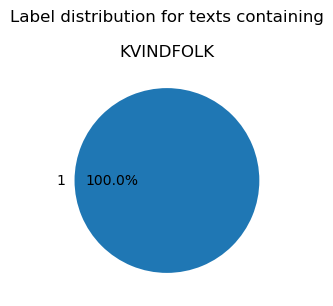

In [8]:
both = pd.DataFrame([X_train_preproc, y_train_orig]).T
kvindfolk = both[both['tweet'].apply(lambda x: 'kvindfolk' in x)]
display(kvindfolk)
plt.figure(figsize=(3,3))
plt.pie(kvindfolk['label'].value_counts().values,
        labels = kvindfolk['label'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Label distribution for texts containing\n\nKVINDFOLK")
plt.show()

,tweet,label
id,,
625,flot tøs,1


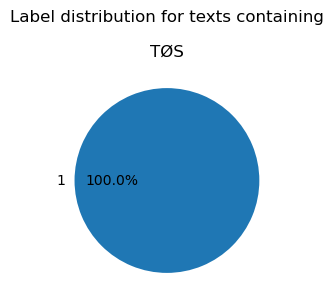

In [10]:
tøs = both[both['tweet'].apply(lambda x: 'tøs' in x)]
display(tøs)
plt.figure(figsize=(3,3))
plt.pie(tøs['label'].value_counts().values,
        labels = tøs['label'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Label distribution for texts containing\n\nTØS")
plt.show()

,tweet,label
id,,


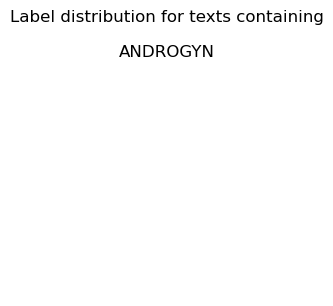

In [9]:
androgyn = both[both['tweet'].apply(lambda x: 'androgyn' in x)]
display(androgyn)
plt.figure(figsize=(3,3))
plt.pie(androgyn['label'].value_counts().values,
        labels = androgyn['label'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Label distribution for texts containing\n\nANDROGYN")
plt.show()